# Deep Learning Project
Your task is to create a new notebook modeled after this one, where:
- You've put all of your cleaning and prepration steps into a functions you load and use in a module.
- You create and train a simple appropriate model for your task.
- You assess the performance using the appropriate metric for your task.
- Compare the performance with your previous best non Deep Neural Network model. This probably will mean you copy and paste your training from your other notebook into this notebook.

# Standard Project Loading

In [1]:
from process import * # module that contains data preprocessing and cleaning (includes libraries)
from datetime import datetime
import numpy as np
import pandas as pd
import pylab
import calendar
from scipy import stats
import seaborn as sns
from sklearn import model_selection, preprocessing
from scipy.stats import kendalltau
import warnings
import matplotlib.pyplot as plt
import pandas
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/train_2016_v2.csv',parse_dates=["transactiondate"] )
props = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/property_2016.csv')
sample = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/sample_submission.csv')

for c in props.columns:
    props[c]=props[c].fillna(-1)
    if props[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(props[c].values))
        props[c] = lbl.transform(list(props[c].values))

In [3]:
train_df = train.merge(props, how='left',on='parcelid')
train_df.head(5)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12643413,0.0218,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_df["transactiondate"] = pd.to_datetime(train_df["transactiondate"])
train_df["transactiondate_year"] = train_df["transactiondate"].dt.year
train_df["transactiondate_month"] = train_df["transactiondate"].dt.month
train_df['transactiondate_quarter'] = train_df['transactiondate'].dt.quarter
train_df["transactiondate"] = train_df["transactiondate"].dt.day

In [5]:
from scipy.stats import skew

def impute_missing_values(column):
    if train_df[column].dtype == 'object':
        # Categorical data: Use mode
        mode = train_df[column].mode()[0]
        train_df[column].fillna(mode, inplace=True)
    else:
        # Numeric data: Decide between mean and median based on skewness
        if skew(train_df[column].dropna()) > 1 or skew(train_df[column].dropna()) < -1:
            # Highly skewed data: Use median
            median = train_df[column].median()
            train_df[column].fillna(median, inplace=True)
        else:
            # Normally distributed data: Use mean
            mean = train_df[column].mean()
            train_df[column].fillna(mean, inplace=True)

In [6]:
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        impute_missing_values(col)

In [7]:
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode','fireplacecnt', 'fireplaceflag'], axis=1)
y_train = train_df["logerror"]

x_test = sample.merge(props,how='left',on='parcelid')

In [8]:
y_mean = np.mean(y_train)
print(x_train.shape, y_train.shape)
train_columns = x_train.columns

(90275, 56) (90275,)


In [9]:
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# Keras Deep Learning

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Conv1D,MaxPooling1D
from keras.layers import Dropout, BatchNormalization, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

2024-04-24 10:40:21.291514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 10:40:21.339410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 10:40:21.339960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 10:40:22.143292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
count = 8
len_x=int(x_train.shape[1])

model = Sequential()
model.add(Conv1D(filters=20, kernel_size=10 ,strides=10,     
                  input_shape = (len_x,1), kernel_initializer= 'uniform',      
                  activation= 'relu'))
model.add(MaxPooling1D(pool_size=2, strides=10, padding='same'))
model.add(Dropout(.17))
model.add(LSTM(units = 150 , kernel_initializer = 'normal', activation = 'softmax',return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(units = 150 , kernel_initializer = 'normal', activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(.32))
model.add(Dense(units = 75, kernel_initializer = 'normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.22))
model.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.22))
model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])

model.summary()

2024-04-24 10:40:25.460411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 10:40:25.460959: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 20)             220       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 20)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 20)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 150)            102600    
                                                                 
 batch_normalization (BatchN  (None, 1, 150)           600       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1, 150)            0

### Our model is using a total of 18 layers, now let's fit and plot our loss curves

Epoch 1/10
2257/2257 [==============================] - 26s 10ms/step - loss: 0.0733 - accuracy: 0.0095 - val_loss: 0.0659 - val_accuracy: 0.0091
Epoch 2/10
2257/2257 [==============================] - 23s 10ms/step - loss: 0.0694 - accuracy: 0.0095 - val_loss: 0.0662 - val_accuracy: 0.0091
Epoch 3/10
2257/2257 [==============================] - 22s 10ms/step - loss: 0.0690 - accuracy: 0.0095 - val_loss: 0.0661 - val_accuracy: 0.0091
Epoch 4/10
2257/2257 [==============================] - 22s 10ms/step - loss: 0.0688 - accuracy: 0.0095 - val_loss: 0.0661 - val_accuracy: 0.0091
Epoch 5/10
2257/2257 [==============================] - 22s 10ms/step - loss: 0.0687 - accuracy: 0.0095 - val_loss: 0.0662 - val_accuracy: 0.0091
Epoch 6/10
2257/2257 [==============================] - 23s 10ms/step - loss: 0.0687 - accuracy: 0.0095 - val_loss: 0.0663 - val_accuracy: 0.0091
Epoch 7/10
2257/2257 [==============================] - 23s 10ms/step - loss: 0.0687 - accuracy: 0.0095 - val_loss: 0.0663 -

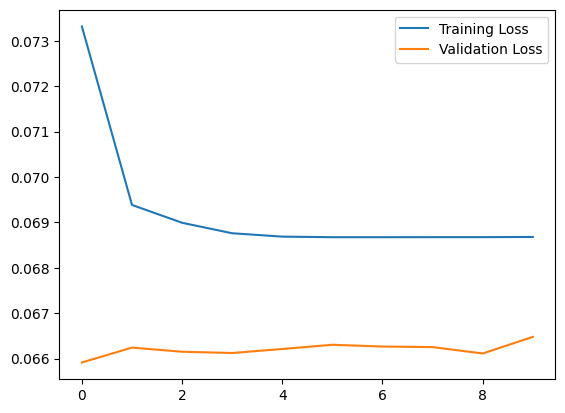

In [12]:
import matplotlib.pyplot as plt

# Fit the model on training data and save the training history
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

# Model Performance

In [14]:
scores = model.evaluate(x_test, y_train)
print(scores)

2822/2822 [==============================] - 11s 4ms/step - loss: 0.0682 - accuracy: 0.0094
[0.068210668861866, 0.009382442571222782]


It seems our model has a loss of 0.0682 and an accuracy score of 0.0094
- Model only accurately 0.94% of instances in the dataset
- Our loss value is extremely low which shows our model is doing well minimalizing loss

Accuracy likely is low due to misclassification, class imbalance or other issues. Other metrics might be better to use like MSE, RMSE, R-Squared and Adjusted R-Squared

# Model Comparison with XGBoost

In [23]:
from sklearn.preprocessing import LabelEncoder

for c in props.columns: # Converts all categorical values to numerical values via Label Encoding
    props[c]=props[c].fillna(-1)
    if props[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(props[c].values))
        props[c] = lbl.transform(list(props[c].values))

train_df = train.merge(props, how='left', on='parcelid') #Merged the old dataset with the converted properties set

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
x_test = props.drop(['parcelid'], axis=1)
# printing out the shape        
print('Shape of train dataset: {}\nShape of test dataset: {}'.format(x_train.shape, x_test.shape))

# taking out potential outliers to fit our model better
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.42 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

Shape of train dataset: (90275, 57)
Shape of test dataset: (90274, 57)


In [25]:
import xgboost as xgb
# Parameters for XG Boosting
xgb_params = {
    'eta': 0.033,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [26]:
# Creating Cross-Validation Set
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=500,
                   early_stopping_rounds=5,
                   verbose_eval=10, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

[0]	train-mae:0.05331	test-mae:0.05331
[10]	train-mae:0.05328	test-mae:0.05331
[12]	train-mae:0.05327	test-mae:0.05331
8


In [27]:
# training our model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
pred = model.predict(dtest)
y_pred=[]

# Printing out our MAE scores for the train and test sets
for i,predict in enumerate(pred):
    y_pred.append(str(round(predict,10)))
y_pred=np.array(y_pred)

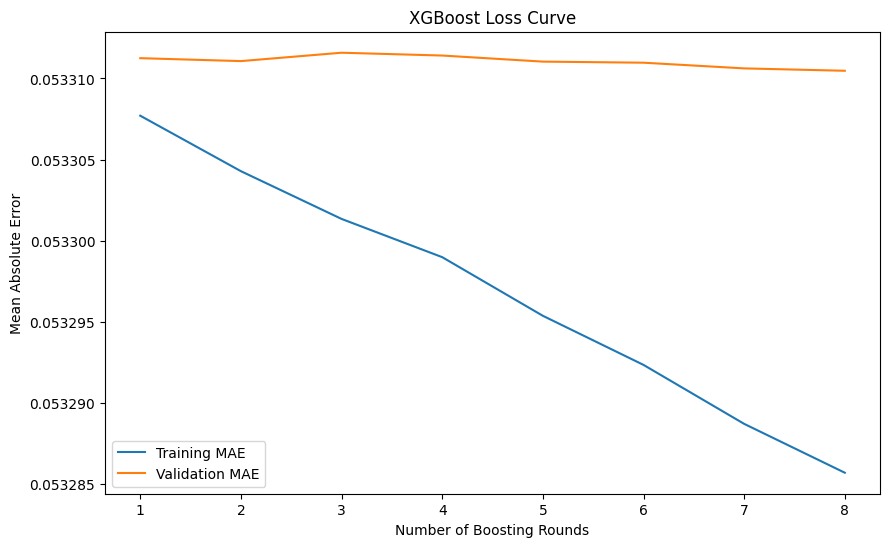

In [29]:
# Extract mean absolute error values from cross-validation results
train_mae = cv_result['train-mae-mean']
test_mae = cv_result['test-mae-mean']

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_rounds + 1), train_mae, label='Training MAE')
plt.plot(range(1, num_boost_rounds + 1), test_mae, label='Validation MAE')
plt.title('XGBoost Loss Curve')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Conclusions

In general, it seems that our original XGBoost model does a better job in terms of accuracy and loss compared to the Keras Deep Learning model we made. 

Some improvements I do think that we can do is try fixing the holes in the dataset if any do exist, use more layers and attempt a better model by using Transfer Learning if possible